# Mnist tutorial

Basic tutorial to show how to train a simple diffusion model on Mnist

In [1]:
# Jax hardware warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Install dependencies if needed

# !pip install datasets
# !pip install matplotlib
# !pip install orbax
# !pip install tqdm

In [3]:
import jax
import jax.numpy as jnp
import optax

from datasets import load_dataset
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt

from grox.denoisers import VPDenoiser
from grox.solvers import EulerMaruyama
from grox.schedules import VP_schedule
from grox.XDEs import EmdODE, ProbODE
from grox.networks.unet import UNet


# Load mnist
Load the data and normalize the data to the range [-0.5, 0.5]. Visualize it and print the shapes

(28, 28, 1)


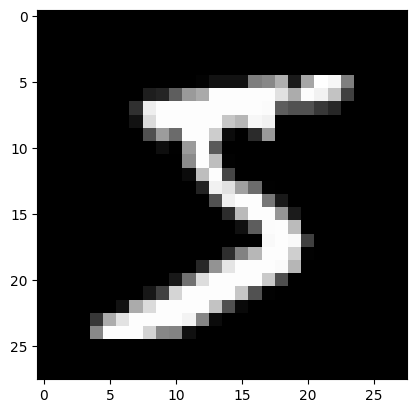

In [4]:
def transform(rows):
    rows["image"] = list(map(lambda x: jnp.array(x)[..., None] / 255 - 0.5, rows["image"]))
    return rows


mnist = load_dataset("mnist", split="train", keep_in_memory=True)
mnist = mnist.with_transform(transform)

print(mnist[0]['image'].shape)
plt.imshow(mnist[0]['image'], cmap='gray')
plt.show()

# Initialize UNet backbone and denoiser
This toturial uses the defualt VP schedule from Song et al.

In [5]:
key = jax.random.key(42)

unet = UNet(
            hidden_channels_per_layer=[32, 64],
            blocks_per_layer=(3, 3),
            out_channels=1,
            emb_features=32,
            kernel_size=(9, 9),
)

optimizer = optax.adam(learning_rate=5e-5)
key, init_key = jax.random.split(key)

out, params = unet.init_with_output(
    init_key, mnist[0]['image'][None], jnp.array([1.0])
)
opt_state = optimizer.init(params)

scale_schedule, sigma_schedule = VP_schedule(beta_min=1e-3, beta_max=3.)
denoiser = VPDenoiser(unet, scale_schedule, sigma_schedule)


E1211 13:25:12.011583 1046428 hlo_lexer.cc:443] Failed to parse int literal: 894515288310727292233


# Train
Takes ~20min on a GPU. The loss is plotted in log scale.

100%|██████████| 20/20 [21:32<00:00, 64.64s/it, loss=0.010034681]


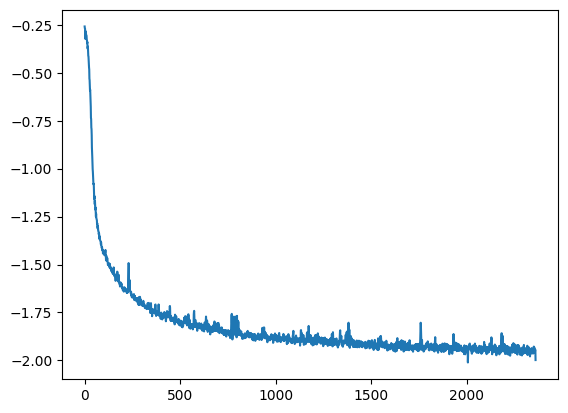

In [6]:
epochs = 20
batch_size = 512


def create_loss_and_step(denoiser, optimizer):
    def loss_fn(params, batch, key):
        noise_key, ts_key = jax.random.split(key)
        ts = jax.random.uniform(ts_key, (batch.shape[0],), minval=0.0, maxval=1)
        noise = jax.random.normal(noise_key, batch.shape)

        sigma = denoiser.sigma_schedule(ts)
        sigma = sigma.reshape(-1, 1, 1, 1)

        noise = noise * sigma
        x_denoised = denoiser(params, batch + noise, ts)

        weights = 1 / (sigma**2 + 1)
        error = x_denoised - batch
        loss = jnp.mean(jnp.mean(error**2, axis=(1, 2, 3)) * weights)
        return loss

    @jax.jit
    def train_step(params, batch, opt_state, rng):
        loss, grads = jax.value_and_grad(loss_fn)(params, batch, rng)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, grads

    return loss_fn, train_step

_, train_step = create_loss_and_step(denoiser, optimizer)

losses = []
bar = tqdm(range(epochs))
for e in bar:

    for batch in mnist.shuffle(keep_in_memory=True).iter(batch_size=batch_size):
        batch = batch['image']
        batch = jnp.stack(batch)
        key, step_key = jax.random.split(key)


        params, opt_state, loss, grads = train_step(
            params, batch, opt_state, step_key
        )
        losses.append(loss)

    bar.set_postfix(loss=loss)



plt.plot(jnp.log10(jnp.stack(losses)))
plt.show()

# Sample a sample

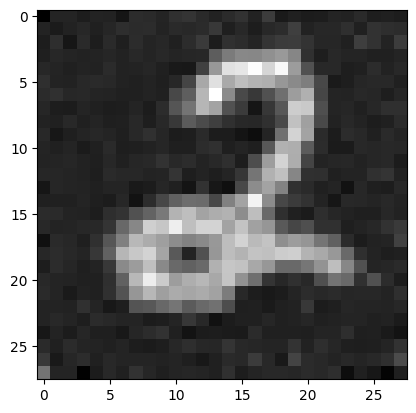

In [7]:
sampling_steps = 500

ts = jnp.linspace(1e-3, 0.999, sampling_steps)

key, sample_key, solver_key = jax.random.split(key, 3)

x0 = jax.random.normal(sample_key, (1, *mnist[0]['image'].shape))
scale = denoiser.scale_schedule(1.0)
sigma = denoiser.sigma_schedule(1.0)
x0 = x0 * sigma * scale

ode = EmdODE(
    denoiser=lambda x, t: denoiser(params, x, t),
    scale_schedule=denoiser.scale_schedule,
    sigma_schedule=denoiser.sigma_schedule,
)

solver = EulerMaruyama(
    drift=ode.drift, diffusion=ode.diffusion, ts=1 - ts
)


samples, _ = solver.solve(x0, solver_key)

plt.imshow(samples[0], cmap='gray')
plt.show()